In [3]:
# -*- coding: utf-8 -*-
# Deprem verilerini 3 kanallı (Z,N,E) HDF5 formatına dönüştürme
# P ve S faz etiketleri de oluşturulur
# Eksik kanallar sıfır ile doldurulur
# Kayıtlar sabit uzunlukta (60s) ve örnekleme hız
# 100 Hz olacak şekilde yeniden örneklenir
# P ve S fazları STA/LTA ile otomatik olarak tespit edilir
# Eksik fazlar için etiketler boş bırakılır
import os, glob, h5py, warnings, traceback
import numpy as np
import pandas as pd
from obspy import read, Stream, UTCDateTime
from obspy.signal.filter import bandpass
from obspy.signal.trigger import classic_sta_lta, trigger_onset
from tqdm import tqdm

# =========================
# PARAMETRELER
# =========================
DATA_DIR        = "/home/comp2/hazal_deprem/deprem_veri"
OUT_DIR         = "dataset_sb"
H5_NAME         = "waveforms_3ch_ps.hdf5"
CSV_NAME        = "metadata_3ch_ps.csv"

TARGET_FS       = 100.0
BP_LO, BP_HI    = 1.0, 20.0
TARGET_LEN_SEC  = 60.0
TARGET_LEN      = int(TARGET_FS * TARGET_LEN_SEC)

STA_SEC, LTA_SEC = 0.5, 3.0
TRIG_ON, TRIG_OFF = 2.0, 1.0       # bir tık daha hassas
MIN_GAP_SEC     = 0.35
FALLBACK_WIN_P  = 0.8
FALLBACK_WIN_S  = 1.2

# DAHA AZ SKIP İÇİN:
REQUIRE_BOTH_P_AND_S = False       # <— öneri: P varsa kaydet; S yoksa da dursun
NORMALIZE_PER_TRACE  = True

# Z/N/E’yi eşleştirirken zaman toleransı:
ALIGN_TOL_SEC   = 2.0

def chan_letter(code: str) -> str:
    return (code[-1].upper() if code else "?")

def preprocess_and_resample(tr, target_fs, bp_lo, bp_hi):
    tr = tr.copy()
    tr.detrend("demean")
    tr.detrend("linear")
    fs = tr.stats.sampling_rate
    if abs(fs - target_fs) > 1e-6:
        tr.resample(target_fs)
    tr.data = bandpass(tr.data, bp_lo, bp_hi, df=target_fs, corners=4, zerophase=True)
    return tr

def rms_normalize(x, eps=1e-8):
    return x / (np.sqrt(np.mean(x**2) + eps) + eps)

def pad_or_crop(arr, target_len):
    if arr.ndim == 1:
        n = arr.shape[0]
        if n >= target_len: return arr[:target_len]
        out = np.zeros(target_len, dtype=arr.dtype); out[:n] = arr; return out
    elif arr.ndim == 2:
        c, n = arr.shape
        if n >= target_len: return arr[:, :target_len]
        out = np.zeros((c, target_len), dtype=arr.dtype); out[:, :n] = arr; return out
    else:
        raise ValueError("pad_or_crop expects 1D or 2D")

def first_trigger_on_off(cft, on=TRIG_ON, off=TRIG_OFF):
    idx = trigger_onset(cft, on, off)
    if len(idx) == 0: return None, None
    return idx[0][0], idx[0][1]

def pick_P_S(z_sig, n_sig, e_sig, fs):
    nsta = int(STA_SEC * fs)
    nlta = int(LTA_SEC * fs)
    if len(z_sig) < nlta or len(n_sig) < nlta or len(e_sig) < nlta:
        return None, None, None, None
    nsta = int(STA_SEC * fs); nlta = int(LTA_SEC * fs)
    if nsta < 1 or nlta <= nsta: return None, None, None, None

    cft_z = classic_sta_lta(z_sig, nsta, nlta)
    p_on, p_off = first_trigger_on_off(cft_z, TRIG_ON, TRIG_OFF)

    h_sig = np.sqrt(n_sig**2 + e_sig**2)
    cft_h = classic_sta_lta(h_sig, nsta, nlta)

    s_on, s_off = None, None
    if p_on is not None:
        start_search = (p_off if p_off is not None else p_on) + int(MIN_GAP_SEC * fs)
        for a, b in trigger_onset(cft_h, TRIG_ON, TRIG_OFF):
            if a >= start_search:
                s_on, s_off = a, b
                break
    else:
        s_on, s_off = first_trigger_on_off(cft_h, TRIG_ON, TRIG_OFF)

    return p_on, p_off, s_on, s_off

def build_label_vector(length, p_on, p_off, s_on, s_off, fs):
    y = np.zeros(length, dtype=np.int8)
    if p_on is not None:
        pend = p_off if (p_off and p_off > p_on) else min(length, p_on + int(FALLBACK_WIN_P * fs))
        pend = max(pend, p_on + 1); pend = min(pend, length)
        y[p_on:pend] = 1
    if s_on is not None:
        send = s_off if (s_off and s_off > s_on) else min(length, s_on + int(FALLBACK_WIN_S * fs))
        send = max(send, s_on + 1); send = min(send, length)
        y[s_on:send] = 2
    return y

# -------- Zaman toleranslı eşleştirme --------
def group_traces_with_tolerance(data_dir, tol_sec=ALIGN_TOL_SEC):
    files = glob.glob(os.path.join(data_dir, "**/*.mseed"), recursive=True)
    print(f"{len(files)} mseed dosyası bulundu")
    # (net, sta) -> list of groups [{start: UTCDateTime, Z: np.array or None, N:..., E:...}]
    by_station = {}
    for f in tqdm(files, desc="Dosyalar okunuyor"):
        try:
            st = read(f)
        except Exception as e:
            warnings.warn(f"Okuma hatası: {f} | {e}")
            continue
        for tr in st:
            net, sta = tr.stats.network, tr.stats.station
            ch = chan_letter(tr.stats.channel)
            if ch not in ("Z","N","E"): 
                continue
            # preprocess & resample BEFORE grouping to have comparable arrays
            try:
                tr_p = preprocess_and_resample(tr, TARGET_FS, BP_LO, BP_HI)
            except Exception:
                warnings.warn(f"Önişleme hatası: {tr.id}\n{traceback.format_exc()}")
                continue
            start = tr_p.stats.starttime
            data = tr_p.data.astype(np.float32)

            key = (net, sta)
            if key not in by_station:
                by_station[key] = []

            # uygun grup ara (start farkı <= tol_sec)
            placed = False
            for g in by_station[key]:
                if abs(g["start"] - start) <= tol_sec:
                    g[ch] = data; placed = True; break
            if not placed:
                by_station[key].append({"start": start, "Z": None, "N": None, "E": None})
                by_station[key][-1][ch] = data

    # düz listeye çevir
    groups = {}
    for (net, sta), glist in by_station.items():
        for i, g in enumerate(glist):
            k = f"{net}.{sta}:{g['start'].strftime('%Y%m%dT%H%M%S')}"
            groups[k] = {"Z": g["Z"], "N": g["N"], "E": g["E"]}
    return groups

# ================= ÇALIŞTIR =================
os.makedirs(OUT_DIR, exist_ok=True)
h5_path  = os.path.join(OUT_DIR, H5_NAME)
csv_path = os.path.join(OUT_DIR, CSV_NAME)

groups = group_traces_with_tolerance(DATA_DIR, ALIGN_TOL_SEC)

meta = []
saved = 0
skipped_none_all = 0
skipped_too_short = 0
skipped_no_P = 0
skipped_no_S = 0
skipped_no_PS = 0

with h5py.File(h5_path, "w") as h5:
    for key, chans in tqdm(groups.items(), desc="Grup işleniyor"):
        z, n, e = chans.get("Z"), chans.get("N"), chans.get("E")
        if z is None and n is None and e is None:
            skipped_none_all += 1; continue

        # eksikler 0 ile
        if z is None: z = np.zeros(1, dtype=np.float32)
        if n is None: n = np.zeros_like(z)
        if e is None: e = np.zeros_like(z)

        min_len = min(len(z), len(n), len(e))
        if min_len < 200:  # çok kısa kayıtları ele
            skipped_too_short += 1; continue
        z, n, e = z[:min_len], n[:min_len], e[:min_len]

        if NORMALIZE_PER_TRACE:
            z = rms_normalize(z); n = rms_normalize(n); e = rms_normalize(e)

        # --- P/S pick (pad/crop'tan ÖNCE) ---
        p_on, p_off, s_on, s_off = pick_P_S(z, n, e, TARGET_FS)

        # şimdi sabitle
        z = pad_or_crop(z, TARGET_LEN)
        n = pad_or_crop(n, TARGET_LEN)
        e = pad_or_crop(e, TARGET_LEN)

        y = build_label_vector(TARGET_LEN, p_on, p_off, s_on, s_off, TARGET_FS)

        hasP = (1 in y); hasS = (2 in y)

        if REQUIRE_BOTH_P_AND_S:
            if (not hasP) and (not hasS):
                skipped_no_PS += 1; continue
            if not hasP:
                skipped_no_P += 1; continue
            if not hasS:
                skipped_no_S += 1; continue
        else:
            if (not hasP) and (not hasS):
                skipped_no_PS += 1; continue  # tamamen boşsa atla

        data3 = np.stack([z, n, e], axis=0)
        grp = h5.create_group(key)
        grp.create_dataset("data", data=data3, compression="gzip")
        grp.create_dataset("y",    data=y,    compression="gzip")

        meta.append({
            "trace_name": key, "length": int(TARGET_LEN), "fs": TARGET_FS,
            "has_P": int(hasP), "has_S": int(hasS),
            "p_on": int(p_on) if p_on is not None else -1,
            "p_off": int(p_off) if p_off is not None else -1,
            "s_on": int(s_on) if s_on is not None else -1,
            "s_off": int(s_off) if s_off is not None else -1,
        })
        saved += 1

pd.DataFrame(meta).to_csv(csv_path, index=False)

print("\n✅ Dönüştürme tamamlandı")
print(f"- HDF5: {os.path.abspath(h5_path)}")
print(f"- CSV : {os.path.abspath(csv_path)}")
print(f"- Kaydedilen örnek: {saved}")
print(f"- Skip (hepsi None): {skipped_none_all}")
print(f"- Skip (çok kısa):   {skipped_too_short}")
print(f"- Skip (P yok):      {skipped_no_P}")
print(f"- Skip (S yok):      {skipped_no_S}")
print(f"- Skip (P&S yok):    {skipped_no_PS}")


243 mseed dosyası bulundu


Grup işleniyor: 100%|██████████| 77556/77556 [01:01<00:00, 1270.91it/s]



✅ Dönüştürme tamamlandı
- HDF5: /home/comp2/hazal_deprem/code/dataset_sb/waveforms_3ch_ps.hdf5
- CSV : /home/comp2/hazal_deprem/code/dataset_sb/metadata_3ch_ps.csv
- Kaydedilen örnek: 36372
- Skip (hepsi None): 0
- Skip (çok kısa):   28334
- Skip (P yok):      0
- Skip (S yok):      0
- Skip (P&S yok):    12850


In [1]:
import os, h5py, math, random, numpy as np
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# tekrar üretilebilirlik
def set_seed(s=42):
    random.seed(s); np.random.seed(s)
    torch.manual_seed(s); torch.cuda.manual_seed_all(s)
set_seed(42)

# yol ve hiperparametreler
H5_PATH = "/home/comp2/hazal_deprem/code/dataset_sb/waveforms_3ch_ps.hdf5"
BATCH_SIZE = 8
LR = 1e-4
EPOCHS = 50
PATIENCE = 6  # early stopping
NUM_WORKERS = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [2]:
# HDF5’i okuma (anahtarlar + istasyon kimliği çıkarma)
# HDF5 iç yapısı: grup adı "NET.STA:YYYYmmddTHHMMSS", içinde:
#  - data: (3, L)
#  - y   : (L,) -> 0=boş, 1=P, 2=S

with h5py.File(H5_PATH, "r") as f:
    all_keys = list(f.keys())
print("Toplam örnek:", len(all_keys))

def station_id_from_key(k: str):
    # "NET.STA:timestamp" -> "NET.STA"
    return k.split(":")[0]

# istasyon bazlı kümeler (sızıntıyı önlemek için aynı STA train/val/test’e aynı anda girmesin)
stations = sorted({station_id_from_key(k) for k in all_keys})
print("İstasyon sayısı:", len(stations))


Toplam örnek: 36372
İstasyon sayısı: 281


In [4]:
# istasyonları önce train/val/test ayır, sonra o istasyonların tüm kayıtlarını ilgili bölüme ata
train_stas, test_stas = train_test_split(stations, test_size=0.2, random_state=42)
train_stas, val_stas  = train_test_split(train_stas, test_size=0.2, random_state=42)

def keys_for(sta_list):
    sset = set(sta_list)
    return [k for k in all_keys if station_id_from_key(k) in sset]

train_keys = keys_for(train_stas)
val_keys   = keys_for(val_stas)
test_keys  = keys_for(test_stas)

print(f"Train: {len(train_keys)} | Val: {len(val_keys)} | Test: {len(test_keys)}")



Train: 23316 | Val: 5993 | Test: 7063


In [5]:
#Dataset sınıfı (mask’li hedef; 0’lar loss’tan hariç)
class PhaseNetH5(Dataset):
    """
    HDF5 PhaseNet formatı: data (3, L), y (L,)
    y: 0=boş/alakasız, 1=P, 2=S
    """
    def __init__(self, h5_path, keys):
        self.h5_path = h5_path
        self.keys = keys

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        key = self.keys[idx]
        with h5py.File(self.h5_path, "r") as f:
            x = f[key]["data"][:]  # (3, L)
            y = f[key]["y"][:]     # (L,)

        # tensöre çevir
        x = torch.tensor(x, dtype=torch.float32)             # (3, L)
        y = torch.tensor(y, dtype=torch.long)                # (L,)
        return x, y

# DataLoader'lar
pin = (device.type == "cuda")
train_ds = PhaseNetH5(H5_PATH, train_keys)
val_ds   = PhaseNetH5(H5_PATH, val_keys)
test_ds  = PhaseNetH5(H5_PATH, test_keys)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=pin, drop_last=False)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=pin, drop_last=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=pin, drop_last=False)


In [6]:
#Modeli yükle (pretrained PhaseNet, 3-sınıf çıkış). Loss: CE(ignore_index=0)
import seisbench.models as sbm

model = sbm.PhaseNet.from_pretrained("ethz").to(device)
# Çıkış: (B, 3, L)  -> sınıflar: [Noise, P, S]  (pretrained böyle)
# Bizim y: 0=boş, 1=P, 2=S. 0'ları loss'tan düşmek için ignore_index=0 kullanıyoruz.
criterion = nn.CrossEntropyLoss(ignore_index=0)

optimizer = optim.Adam(model.parameters(), lr=LR)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)


/tmp/ipykernel_14253/3103502185.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))


/tmp/ipykernel_14253/3732946393.py:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))


Device: cuda


Train 1/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[01] Train: 1.0374 | Val: 0.8470 | Train F1: 0.530 | Val F1: 0.750 | LR: 1.00e-04


Train 2/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[02] Train: 0.8016 | Val: 0.7492 | Train F1: 0.795 | Val F1: 0.839 | LR: 1.00e-04


Train 3/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[03] Train: 0.7524 | Val: 0.7205 | Train F1: 0.841 | Val F1: 0.868 | LR: 1.00e-04


Train 4/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[04] Train: 0.7319 | Val: 0.7025 | Train F1: 0.861 | Val F1: 0.886 | LR: 1.00e-04


Train 5/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[05] Train: 0.7172 | Val: 0.6958 | Train F1: 0.876 | Val F1: 0.892 | LR: 1.00e-04


Train 6/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[06] Train: 0.7084 | Val: 0.6936 | Train F1: 0.886 | Val F1: 0.893 | LR: 1.00e-04


Train 7/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[07] Train: 0.7009 | Val: 0.6851 | Train F1: 0.894 | Val F1: 0.904 | LR: 1.00e-04


Train 8/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[08] Train: 0.6958 | Val: 0.6808 | Train F1: 0.899 | Val F1: 0.909 | LR: 1.00e-04


Train 9/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[09] Train: 0.6911 | Val: 0.6801 | Train F1: 0.904 | Val F1: 0.911 | LR: 1.00e-04


Train 10/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[10] Train: 0.6881 | Val: 0.6806 | Train F1: 0.908 | Val F1: 0.908 | LR: 1.00e-04


Train 11/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[11] Train: 0.6851 | Val: 0.6762 | Train F1: 0.911 | Val F1: 0.915 | LR: 1.00e-04


Train 12/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[12] Train: 0.6829 | Val: 0.6725 | Train F1: 0.914 | Val F1: 0.918 | LR: 1.00e-04


Train 13/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[13] Train: 0.6798 | Val: 0.6735 | Train F1: 0.917 | Val F1: 0.919 | LR: 1.00e-04


Train 14/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[14] Train: 0.6772 | Val: 0.6682 | Train F1: 0.920 | Val F1: 0.924 | LR: 1.00e-04


Train 15/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[15] Train: 0.6753 | Val: 0.6696 | Train F1: 0.922 | Val F1: 0.922 | LR: 1.00e-04


Train 16/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[16] Train: 0.6715 | Val: 0.6690 | Train F1: 0.926 | Val F1: 0.922 | LR: 1.00e-04


Train 17/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[17] Train: 0.6704 | Val: 0.6636 | Train F1: 0.928 | Val F1: 0.929 | LR: 1.00e-04


Train 18/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[18] Train: 0.6698 | Val: 0.6638 | Train F1: 0.928 | Val F1: 0.929 | LR: 1.00e-04


Train 19/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[19] Train: 0.6684 | Val: 0.6620 | Train F1: 0.930 | Val F1: 0.931 | LR: 1.00e-04


Train 20/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[20] Train: 0.6649 | Val: 0.6609 | Train F1: 0.933 | Val F1: 0.933 | LR: 1.00e-04


Train 21/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[21] Train: 0.6648 | Val: 0.6629 | Train F1: 0.934 | Val F1: 0.930 | LR: 1.00e-04


Train 22/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[22] Train: 0.6635 | Val: 0.6582 | Train F1: 0.935 | Val F1: 0.937 | LR: 1.00e-04


Train 23/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[23] Train: 0.6627 | Val: 0.6591 | Train F1: 0.936 | Val F1: 0.935 | LR: 1.00e-04


Train 24/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[24] Train: 0.6616 | Val: 0.6577 | Train F1: 0.937 | Val F1: 0.937 | LR: 1.00e-04


Train 25/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[25] Train: 0.6595 | Val: 0.6567 | Train F1: 0.940 | Val F1: 0.938 | LR: 1.00e-04


Train 26/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[26] Train: 0.6599 | Val: 0.6546 | Train F1: 0.940 | Val F1: 0.941 | LR: 1.00e-04


Train 27/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[27] Train: 0.6576 | Val: 0.6546 | Train F1: 0.942 | Val F1: 0.941 | LR: 1.00e-04


Train 28/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[28] Train: 0.6565 | Val: 0.6564 | Train F1: 0.943 | Val F1: 0.938 | LR: 1.00e-04


Train 29/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[29] Train: 0.6547 | Val: 0.6537 | Train F1: 0.945 | Val F1: 0.942 | LR: 1.00e-04


Train 30/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[30] Train: 0.6557 | Val: 0.6541 | Train F1: 0.944 | Val F1: 0.942 | LR: 1.00e-04


Train 31/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[31] Train: 0.6544 | Val: 0.6537 | Train F1: 0.946 | Val F1: 0.941 | LR: 1.00e-04


Train 32/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[32] Train: 0.6536 | Val: 0.6517 | Train F1: 0.947 | Val F1: 0.945 | LR: 1.00e-04


Train 33/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[33] Train: 0.6526 | Val: 0.6510 | Train F1: 0.948 | Val F1: 0.945 | LR: 1.00e-04


Train 34/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[34] Train: 0.6522 | Val: 0.6521 | Train F1: 0.949 | Val F1: 0.944 | LR: 1.00e-04


Train 35/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[35] Train: 0.6510 | Val: 0.6501 | Train F1: 0.949 | Val F1: 0.947 | LR: 1.00e-04


Train 36/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[36] Train: 0.6492 | Val: 0.6511 | Train F1: 0.952 | Val F1: 0.946 | LR: 1.00e-04


Train 37/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[37] Train: 0.6494 | Val: 0.6498 | Train F1: 0.952 | Val F1: 0.947 | LR: 1.00e-04


Train 38/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[38] Train: 0.6488 | Val: 0.6498 | Train F1: 0.952 | Val F1: 0.947 | LR: 1.00e-04


Train 39/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[39] Train: 0.6483 | Val: 0.6514 | Train F1: 0.952 | Val F1: 0.945 | LR: 1.00e-04


Train 40/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[40] Train: 0.6474 | Val: 0.6536 | Train F1: 0.954 | Val F1: 0.943 | LR: 5.00e-05


Train 41/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[41] Train: 0.6467 | Val: 0.6487 | Train F1: 0.955 | Val F1: 0.949 | LR: 5.00e-05


Train 42/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[42] Train: 0.6462 | Val: 0.6482 | Train F1: 0.955 | Val F1: 0.950 | LR: 5.00e-05


Train 43/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[43] Train: 0.6453 | Val: 0.6487 | Train F1: 0.956 | Val F1: 0.948 | LR: 5.00e-05


Train 44/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[44] Train: 0.6448 | Val: 0.6490 | Train F1: 0.957 | Val F1: 0.948 | LR: 5.00e-05


Train 45/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[45] Train: 0.6447 | Val: 0.6475 | Train F1: 0.957 | Val F1: 0.950 | LR: 5.00e-05


Train 46/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[46] Train: 0.6428 | Val: 0.6493 | Train F1: 0.959 | Val F1: 0.948 | LR: 5.00e-05


Train 47/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[47] Train: 0.6441 | Val: 0.6462 | Train F1: 0.958 | Val F1: 0.952 | LR: 5.00e-05


Train 48/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[48] Train: 0.6431 | Val: 0.6483 | Train F1: 0.958 | Val F1: 0.949 | LR: 5.00e-05


Train 49/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[49] Train: 0.6428 | Val: 0.6482 | Train F1: 0.959 | Val F1: 0.949 | LR: 5.00e-05


Train 50/50:   0%|          | 0/1458 [00:00<?, ?it/s]/tmp/ipykernel_14253/3732946393.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
/tmp/ipykernel_14253/3732946393.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


[50] Train: 0.6431 | Val: 0.6463 | Train F1: 0.958 | Val F1: 0.951 | LR: 2.50e-05

✅ En iyi val loss: 0.6462 | Model: phasenet_best_ps.pth


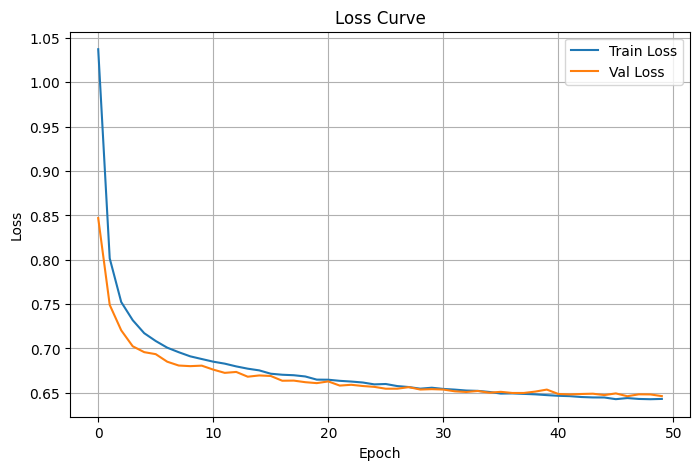

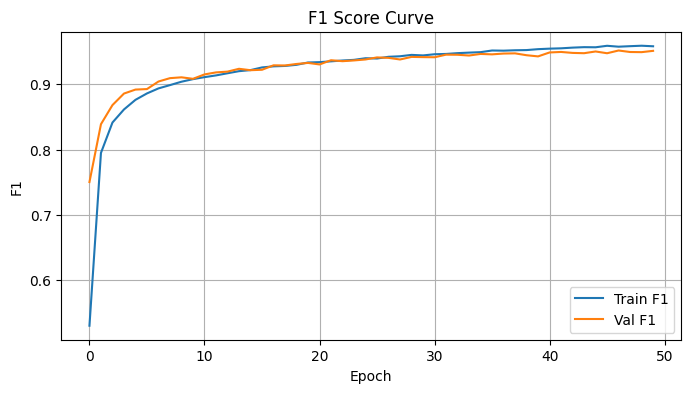

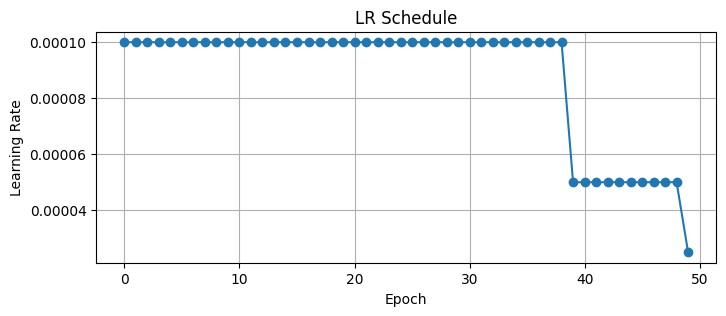

In [7]:
import os, torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seisbench.models as sbm

# ==== Hiperparametreler ====
LR = 1e-4
EPOCHS = 50
BATCH_SIZE = 16
PATIENCE = 6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ==== Model ve optimizer ====
model = sbm.PhaseNet.from_pretrained("ethz").to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0, label_smoothing=0.05)
optimizer = optim.Adam(model.parameters(), lr=LR)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)

# ==== DataLoader ====
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=8, pin_memory=True, persistent_workers=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=8, pin_memory=True, persistent_workers=True)

# ==== Eğitim değişkenleri ====
train_losses, val_losses, lrs = [], [], []
train_f1s, val_f1s = [], []
best_val = float("inf")
best_path = "phasenet_best_ps.pth"
wait = 0

# ==== Eğitim döngüsü ====
for epoch in range(1, EPOCHS+1):
    model.train()
    train_loss, val_loss = 0.0, 0.0
    train_true, train_pred = [], []
    val_true, val_pred = [], []

    # İlk birkaç epoch encoder freeze
    if epoch < 4:
        for p in model.inc.parameters(): p.requires_grad = False
    else:
        for p in model.parameters(): p.requires_grad = True

    # ---- TRAIN ----
    for x, y in tqdm(train_loader, desc=f"Train {epoch}/{EPOCHS}", leave=False):
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
            logits = model(x)
            ce = criterion(logits.permute(0,2,1).reshape(-1,3), y.reshape(-1))
            mask = (y > 0)
            probs = torch.softmax(logits, dim=1)
            noise_penalty = probs[:,0,:][mask].mean()
            loss = ce + 0.1 * noise_penalty

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()

        # F1 için
        pred = logits.argmax(dim=1)
        m = (y > 0)
        train_true.append(y[m].detach().cpu().numpy())
        train_pred.append(pred[m].detach().cpu().numpy())

    train_loss /= len(train_loader)
    ttrue = np.concatenate(train_true) if len(train_true) else np.array([])
    tpred = np.concatenate(train_pred) if len(train_pred) else np.array([])
    train_f1 = f1_score(ttrue, tpred, labels=[1,2], average="macro", zero_division=0) if len(ttrue) else np.nan

    # ---- VALIDATION ----
    model.eval()
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
                logits = model(x)
                ce = criterion(logits.permute(0,2,1).reshape(-1,3), y.reshape(-1))
                mask = (y > 0)
                probs = torch.softmax(logits, dim=1)
                noise_penalty = probs[:,0,:][mask].mean()
                loss = ce + 0.1 * noise_penalty
            val_loss += loss.item()

            pred = logits.argmax(dim=1)
            m = (y > 0)
            val_true.append(y[m].detach().cpu().numpy())
            val_pred.append(pred[m].detach().cpu().numpy())

    val_loss /= len(val_loader)
    scheduler.step(val_loss)

    vtrue = np.concatenate(val_true) if len(val_true) else np.array([])
    vpred = np.concatenate(val_pred) if len(val_pred) else np.array([])
    val_f1 = f1_score(vtrue, vpred, labels=[1,2], average="macro", zero_division=0) if len(vtrue) else np.nan

    train_losses.append(train_loss); val_losses.append(val_loss)
    train_f1s.append(train_f1); val_f1s.append(val_f1)
    lrs.append(optimizer.param_groups[0]['lr'])

    print(f"[{epoch:02d}] Train: {train_loss:.4f} | Val: {val_loss:.4f} | "
          f"Train F1: {train_f1:.3f} | Val F1: {val_f1:.3f} | LR: {optimizer.param_groups[0]['lr']:.2e}")

    # ---- Early stopping ----
    if val_loss < best_val - 1e-5:
        best_val = val_loss
        torch.save(model.state_dict(), best_path)
        wait = 0
    else:
        wait += 1
        if wait >= PATIENCE:
            print(" Early stopping tetiklendi.")
            break

print(f"\n En iyi val loss: {best_val:.4f} | Model: {best_path}")

# ==== GRAFİKLER ====
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss"); plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss Curve"); plt.grid(True); plt.show()

plt.figure(figsize=(8,4))
plt.plot(train_f1s, label="Train F1"); plt.plot(val_f1s, label="Val F1")
plt.xlabel("Epoch"); plt.ylabel("F1"); plt.legend(); plt.title("F1 Score Curve"); plt.grid(True); plt.show()

plt.figure(figsize=(8,3))
plt.plot(lrs, marker="o"); plt.xlabel("Epoch"); plt.ylabel("Learning Rate")
plt.title("LR Schedule"); plt.grid(True); plt.show()


Testing:   0%|          | 0/883 [00:00<?, ?it/s]/tmp/ipykernel_14253/246325389.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):



==== TEST SONUÇLARI ====
              precision    recall  f1-score   support

           P       0.95      0.97      0.96    577937
           S       0.95      0.92      0.93    400614

    accuracy                           0.95    978551
   macro avg       0.95      0.94      0.95    978551
weighted avg       0.95      0.95      0.95    978551



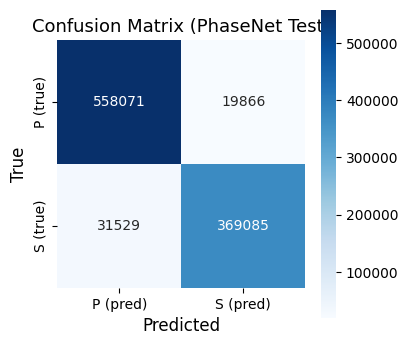

In [9]:
#Test döngüsü
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

model.load_state_dict(torch.load(best_path, map_location=device))
model.eval()

y_true_all, y_pred_all = [], []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Testing", leave=False):
        x = x.to(device)
        y = y.to(device)
        with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
            out = model(x)
        pred = out.argmax(dim=1)
        mask = (y > 0)
        y_true_all.append(y[mask].cpu().numpy())
        y_pred_all.append(pred[mask].cpu().numpy())

y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)

print("\n==== TEST SONUÇLARI ====")
print(classification_report(
    y_true_all, y_pred_all,
    labels=[1, 2],
    target_names=["P", "S"],
    zero_division=0
))

# -----------------------------
# CONFUSION MATRIX
# -----------------------------
cm = confusion_matrix(y_true_all, y_pred_all, labels=[1, 2])
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", square=True,
            xticklabels=["P (pred)", "S (pred)"],
            yticklabels=["P (true)", "S (true)"])
plt.title("Confusion Matrix (PhaseNet Test)", fontsize=13)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.show()


==== TEST SONUÇLARI ====
Accuracy : 0.9475
Precision: 0.9477
Recall   : 0.9435
F1 Score : 0.9454
MAE      : 0.0525
MSE      : 0.0525
RMSE     : 0.2292

              precision    recall  f1-score   support

      P-wave       0.95      0.97      0.96    577937
      S-wave       0.95      0.92      0.93    400614

    accuracy                           0.95    978551
   macro avg       0.95      0.94      0.95    978551
weighted avg       0.95      0.95      0.95    978551



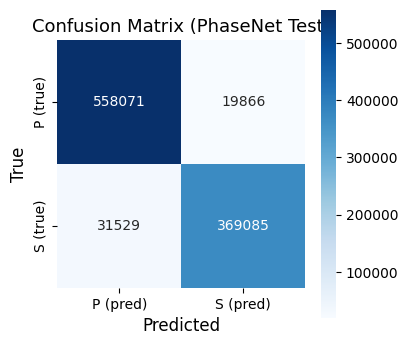

In [10]:
import numpy as np
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             mean_absolute_error, mean_squared_error,
                             classification_report, confusion_matrix)
import seaborn as sns
import matplotlib.pyplot as plt

# y_true_all ve y_pred_all zaten mevcut olmalı
# (örnek: test döngüsünde flatten edip topladığın)
# 0=Noise, 1=P, 2=S

mask = (y_true_all > 0)  # sadece P ve S
y_true_eval = y_true_all[mask]
y_pred_eval = y_pred_all[mask]

# ---- Sınıflandırma metrikleri ----
acc  = accuracy_score(y_true_eval, y_pred_eval)
prec = precision_score(y_true_eval, y_pred_eval, average="macro", zero_division=0)
rec  = recall_score(y_true_eval, y_pred_eval, average="macro", zero_division=0)
f1   = f1_score(y_true_eval, y_pred_eval, average="macro", zero_division=0)

# ---- Regresyon tipi hatalar ----
mae = mean_absolute_error(y_true_eval, y_pred_eval)
mse = mean_squared_error(y_true_eval, y_pred_eval)
rmse = np.sqrt(mse)

print("==== TEST SONUÇLARI ====")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"MAE      : {mae:.4f}")
print(f"MSE      : {mse:.4f}")
print(f"RMSE     : {rmse:.4f}\n")

# ---- Ayrıntılı rapor ----
print(classification_report(y_true_eval, y_pred_eval,
                            labels=[1,2],
                            target_names=["P-wave","S-wave"],
                            zero_division=0))

# ---- Confusion Matrix ----
cm = confusion_matrix(y_true_eval, y_pred_eval, labels=[1,2])
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", square=True,
            xticklabels=["P (pred)", "S (pred)"],
            yticklabels=["P (true)", "S (true)"])
plt.title("Confusion Matrix (PhaseNet Test)", fontsize=13)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.show()


Çalışmamızda, sismik verilerden P ve S dalgalarının tespiti amacıyla önceden eğitilmiş PhaseNet modeli, hazırlanan yerel veri kümesi üzerinde yeniden eğitilmiştir. Modelin performansı, test verileri üzerinde elde edilen çeşitli sınıflandırma ve hata metrikleri ile değerlendirilmiştir. Elde edilen sonuçlar, modelin yüksek genelleme başarısına ve faz ayrımında güvenilir bir performansa sahip olduğunu göstermektedir.

In [13]:
import pandas as pd
from tabulate import tabulate

# Metrix verilerini dictionary olarak tanımla
data = {
    "Metrik": [
        "Accuracy",
        "Precision (macro)",
        "Recall (macro)",
        "F1 Skoru (macro)",
        "MAE",
        "MSE",
        "RMSE"
    ],
    "Değer": [
        0.9475,
        0.9477,
        0.9435,
        0.9454,
        0.0525,
        0.0525,
        0.2292
    ],
    "Yorum": [
        "Modelin tüm test örnekleri içerisindeki genel doğruluk oranıdır. P ve S dalgalarının yaklaşık %94,75’ini doğru sınıfa yerleştirebilmiştir.",
        "Modelin P veya S etiketi verdiği örneklerin %94,77’si doğru tahmin edilmiştir. Yanlış pozitif oranı oldukça düşüktür.",
        "Gerçek P ve S örneklerinin %94,35’i doğru şekilde tespit edilmiştir. Modelin duyarlılığı yüksek düzeydedir.",
        "Precision ve Recall değerlerinin harmonik ortalaması olup modelin genel dengeleme yeteneğini temsil eder. F1>0.94 seviyesi, faz ayrımı açısından literatürde güçlü bir performans olarak değerlendirilmektedir.",
        "Ortalama mutlak hata 0.05 seviyesindedir. Bu, modelin her 20 dalgadan yalnızca birinde yanlış faz tahmini yaptığı anlamına gelir.",
        "Kare hata değeri düşük olup büyük hataların (örneğin tamamen yanlış faz sınıflandırmaları) nadir gerçekleştiğini gösterir.",
        "Hataların karekök ortalaması da düşük olup, modelin tahminlerinin faz sınırlarına yakın olduğunu göstermektedir."
    ]
}

# DataFrame oluştur
df = pd.DataFrame(data)

# Konsolda güzel biçimli görünüm
print(tabulate(df, headers="keys", tablefmt="grid", showindex=False))

# (Opsiyonel) Jupyter için stilize HTML tablo
df.style.set_caption("Tablo 1. PhaseNet modelinin test kümesi üzerindeki performans metrikleri.") \
         .set_table_styles([{
             'selector': 'caption',
             'props': [('caption-side', 'top'), ('font-weight', 'bold'), ('font-size', '14px')]
         }])


+-------------------+---------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Metrik            |   Değer | Yorum                                                                                                                                                                                                           |
+===================+=========+=================================================================================================================================================================================================================+
| Accuracy          |  0.9475 | Modelin tüm test örnekleri içerisindeki genel doğruluk oranıdır. P ve S dalgalarının yaklaşık %94,75’ini doğru sınıfa yerleştirebilmiştir.                                                                      |
+-------------------+---------+-

,Metrik,Değer,Yorum
0,Accuracy,0.947500,"Modelin tüm test örnekleri içerisindeki genel doğruluk oranıdır. P ve S dalgalarının yaklaşık %94,75’ini doğru sınıfa yerleştirebilmiştir."
1,Precision (macro),0.947700,"Modelin P veya S etiketi verdiği örneklerin %94,77’si doğru tahmin edilmiştir. Yanlış pozitif oranı oldukça düşüktür."
2,Recall (macro),0.943500,"Gerçek P ve S örneklerinin %94,35’i doğru şekilde tespit edilmiştir. Modelin duyarlılığı yüksek düzeydedir."
3,F1 Skoru (macro),0.945400,"Precision ve Recall değerlerinin harmonik ortalaması olup modelin genel dengeleme yeteneğini temsil eder. F1>0.94 seviyesi, faz ayrımı açısından literatürde güçlü bir performans olarak değerlendirilmektedir."
4,MAE,0.052500,"Ortalama mutlak hata 0.05 seviyesindedir. Bu, modelin her 20 dalgadan yalnızca birinde yanlış faz tahmini yaptığı anlamına gelir."
5,MSE,0.052500,Kare hata değeri düşük olup büyük hataların (örneğin tamamen yanlış faz sınıflandırmaları) nadir gerçekleştiğini gösterir.
6,RMSE,0.229200,"Hataların karekök ortalaması da düşük olup, modelin tahminlerinin faz sınırlarına yakın olduğunu göstermektedir."
